__Note:__ A detailed summary about my initial plan and approach, along with thought process and findings, can be found at the bottom of this notebook. This summary can also be found in the README of the Github repo.

# Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm

import xgboost as xgb

from utility import getIndices, extractOtherCollinearPair

# Import census dataset

In [2]:
raw_census_df = pd.read_csv("census_labeled.csv")

In [3]:
raw_census_df.head()

,county name,state,county_population_increased_2015_2016,year,female_total_population,female_age_under_5_pct,female_age_5_to_9_pct,female_age_10_to_14_pct,female_age_15_to_19_pct,female_age_20_to_24_pct,...,male_age_40_to_44_pct,male_age_45_to_49_pct,male_age_50_to_54_pct,male_age_55_to_59_pct,male_age_60_to_64_pct,male_age_65_to_69_pct,male_age_70_to_74_pct,male_age_75_to_79_pct,male_age_80_to_84_pct,male_age_85_and_over_pct
0,Stark County,Ohio,False,2010,192651,5.5,6.3,6.0,6.2,5.7,...,7.0,7.4,8.1,7.4,6.2,4.8,3.1,2.6,2.0,1.5
1,Summit County,Ohio,False,2010,279592,5.6,5.8,6.2,6.5,6.1,...,6.8,7.6,8.1,7.5,5.6,3.6,3.3,2.5,2.0,1.2
2,Trumbull County,Ohio,False,2010,108490,5.4,5.9,6.3,6.2,5.0,...,6.7,7.1,8.1,6.9,7.5,5.7,3.0,2.5,2.6,1.5
3,Tuscarawas County,Ohio,False,2010,47279,5.5,5.2,7.7,6.5,4.9,...,5.5,7.2,8.1,6.2,7.2,4.0,4.0,2.4,2.5,1.4
4,Warren County,Ohio,True,2010,105706,6.4,7.0,8.5,6.4,4.2,...,6.9,8.3,7.4,5.2,5.7,3.3,2.3,1.7,1.3,0.7


# Exploring the raw data

In [4]:
raw_census_df.columns # Check columns

Index(['county name', 'state', 'county_population_increased_2015_2016', 'year',
       'female_total_population', 'female_age_under_5_pct',
       'female_age_5_to_9_pct', 'female_age_10_to_14_pct',
       'female_age_15_to_19_pct', 'female_age_20_to_24_pct',
       'female_age_25_to_29_pct', 'female_age_30_to_34_pct',
       'female_age_35_to_39_pct', 'female_age_40_to_44_pct',
       'female_age_45_to_49_pct', 'female_age_50_to_54_pct',
       'female_age_55_to_59_pct', 'female_age_60_to_64_pct',
       'female_age_65_to_69_pct', 'female_age_70_to_74_pct',
       'female_age_75_to_79_pct', 'female_age_80_to_84_pct',
       'female_age_85_and_over_pct', 'male_total_population',
       'male_age_under_5_pct', 'male_age_5_to_9_pct', 'male_age_10_to_14_pct',
       'male_age_15_to_19_pct', 'male_age_20_to_24_pct',
       'male_age_25_to_29_pct', 'male_age_30_to_34_pct',
       'male_age_35_to_39_pct', 'male_age_40_to_44_pct',
       'male_age_45_to_49_pct', 'male_age_50_to_54_pct',
     

In [5]:
raw_census_df.isnull().sum() # Check for null values

county name                              0
state                                    0
county_population_increased_2015_2016    6
year                                     0
female_total_population                  0
female_age_under_5_pct                   0
female_age_5_to_9_pct                    0
female_age_10_to_14_pct                  0
female_age_15_to_19_pct                  0
female_age_20_to_24_pct                  0
female_age_25_to_29_pct                  0
female_age_30_to_34_pct                  0
female_age_35_to_39_pct                  0
female_age_40_to_44_pct                  0
female_age_45_to_49_pct                  0
female_age_50_to_54_pct                  0
female_age_55_to_59_pct                  0
female_age_60_to_64_pct                  0
female_age_65_to_69_pct                  0
female_age_70_to_74_pct                  0
female_age_75_to_79_pct                  0
female_age_80_to_84_pct                  0
female_age_85_and_over_pct               0
male_total_

In [6]:
# Obtain summary statistics
raw_census_df.describe()

,year,female_total_population,female_age_under_5_pct,female_age_5_to_9_pct,female_age_10_to_14_pct,female_age_15_to_19_pct,female_age_20_to_24_pct,female_age_25_to_29_pct,female_age_30_to_34_pct,female_age_35_to_39_pct,...,male_age_40_to_44_pct,male_age_45_to_49_pct,male_age_50_to_54_pct,male_age_55_to_59_pct,male_age_60_to_64_pct,male_age_65_to_69_pct,male_age_70_to_74_pct,male_age_75_to_79_pct,male_age_80_to_84_pct,male_age_85_and_over_pct
count,4951.00000,4.951000e+03,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000,...,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000,4951.000000
mean,2012.50818,1.649779e+05,5.931448,6.226904,6.331711,6.755201,7.051182,6.285821,6.241931,6.025550,...,6.535165,6.817047,7.135407,6.595758,5.805554,4.525369,3.245890,2.271804,1.569622,1.273339
std,1.70711,2.901141e+05,1.128397,1.202464,1.165714,1.412058,2.625605,1.349098,1.049328,1.066695,...,1.071333,0.960629,0.926436,1.086114,1.149389,1.271914,1.143187,0.866287,0.653749,0.591089
min,2010.00000,2.593500e+04,1.700000,1.700000,1.900000,2.100000,0.800000,1.900000,1.800000,0.900000,...,2.400000,2.700000,2.600000,2.900000,2.200000,1.600000,0.700000,0.300000,0.000000,0.000000
25%,2011.00000,4.823750e+04,5.200000,5.500000,5.600000,6.000000,5.600000,5.400000,5.600000,5.400000,...,5.800000,6.200000,6.600000,5.900000,5.000000,3.700000,2.500000,1.700000,1.100000,0.900000
50%,2013.00000,7.830900e+04,5.800000,6.100000,6.300000,6.500000,6.400000,6.100000,6.200000,6.000000,...,6.500000,6.800000,7.200000,6.600000,5.800000,4.400000,3.100000,2.100000,1.500000,1.200000
75%,2014.00000,1.624800e+05,6.600000,6.900000,7.000000,7.200000,7.500000,7.000000,6.800000,6.700000,...,7.200000,7.400000,7.800000,7.300000,6.500000,5.100000,3.700000,2.600000,1.900000,1.600000
max,2015.00000,5.160965e+06,12.800000,11.800000,10.600000,16.500000,23.700000,16.800000,12.800000,11.900000,...,11.700000,10.300000,10.600000,10.800000,11.600000,18.200000,18.300000,11.400000,7.800000,5.200000


In [7]:
# check for unique 'county name' and 'state' combinations: 830 unique combinations
raw_census_df[['county name', 'state']].drop_duplicates()

,county name,state
0,Stark County,Ohio
1,Summit County,Ohio
2,Trumbull County,Ohio
3,Tuscarawas County,Ohio
4,Warren County,Ohio
...,...,...
2584,Ward County,North Dakota
3213,Rice County,Minnesota
3250,Lewis and Clark County,Montana
4342,Broomfield County,Colorado


In [8]:
# Get target variable boolean ratio

raw_census_df['county_population_increased_2015_2016'].value_counts()

True     3323
False    1622
Name: county_population_increased_2015_2016, dtype: int64

In [9]:
raw_census_df[raw_census_df.isnull().any(axis=1)] # return rows with null values

,county name,state,county_population_increased_2015_2016,year,female_total_population,female_age_under_5_pct,female_age_5_to_9_pct,female_age_10_to_14_pct,female_age_15_to_19_pct,female_age_20_to_24_pct,...,male_age_40_to_44_pct,male_age_45_to_49_pct,male_age_50_to_54_pct,male_age_55_to_59_pct,male_age_60_to_64_pct,male_age_65_to_69_pct,male_age_70_to_74_pct,male_age_75_to_79_pct,male_age_80_to_84_pct,male_age_85_and_over_pct
398,Pike County,Kentucky,NaN,2010,33142,5.4,6.2,5.5,5.8,5.4,...,5.8,7.4,8.2,9.3,4.5,4.6,3.2,1.4,1.8,1.0
1472,Pike County,Kentucky,NaN,2011,33157,5.5,5.2,6.2,6.2,5.4,...,8.2,7.3,7.8,7.2,7.7,3.4,4.8,2.5,0.6,1.2
2342,Pike County,Kentucky,NaN,2012,32634,5.4,5.9,6.3,5.3,5.6,...,7.5,6.9,7.9,6.2,8.2,6.4,2.4,1.2,2.2,1.0
3124,Pike County,Kentucky,NaN,2013,32580,6.2,6.0,5.0,5.5,6.3,...,6.8,7.2,8.3,9.8,4.9,5.5,3.3,1.0,2.3,1.6
3954,Pike County,Kentucky,NaN,2014,32172,5.4,4.4,7.4,5.4,6.2,...,8.3,7.1,7.5,8.9,5.8,6.7,2.5,1.5,1.7,1.7
4250,Pike County,Kentucky,NaN,2015,31918,5.7,5.2,5.6,5.1,5.5,...,5.3,6.8,7.2,7.3,7.6,5.3,4.3,2.9,1.9,0.5


In [10]:
# Explore if all "Pike County" rows contain nulls for "county_population_increased_2015_2016"

raw_census_df[raw_census_df['county name'] == 'Pike County'] 

,county name,state,county_population_increased_2015_2016,year,female_total_population,female_age_under_5_pct,female_age_5_to_9_pct,female_age_10_to_14_pct,female_age_15_to_19_pct,female_age_20_to_24_pct,...,male_age_40_to_44_pct,male_age_45_to_49_pct,male_age_50_to_54_pct,male_age_55_to_59_pct,male_age_60_to_64_pct,male_age_65_to_69_pct,male_age_70_to_74_pct,male_age_75_to_79_pct,male_age_80_to_84_pct,male_age_85_and_over_pct
398,Pike County,Kentucky,NaN,2010,33142,5.4,6.2,5.5,5.8,5.4,...,5.8,7.4,8.2,9.3,4.5,4.6,3.2,1.4,1.8,1.0
1472,Pike County,Kentucky,NaN,2011,33157,5.5,5.2,6.2,6.2,5.4,...,8.2,7.3,7.8,7.2,7.7,3.4,4.8,2.5,0.6,1.2
2342,Pike County,Kentucky,NaN,2012,32634,5.4,5.9,6.3,5.3,5.6,...,7.5,6.9,7.9,6.2,8.2,6.4,2.4,1.2,2.2,1.0
3124,Pike County,Kentucky,NaN,2013,32580,6.2,6.0,5.0,5.5,6.3,...,6.8,7.2,8.3,9.8,4.9,5.5,3.3,1.0,2.3,1.6
3954,Pike County,Kentucky,NaN,2014,32172,5.4,4.4,7.4,5.4,6.2,...,8.3,7.1,7.5,8.9,5.8,6.7,2.5,1.5,1.7,1.7
4250,Pike County,Kentucky,NaN,2015,31918,5.7,5.2,5.6,5.1,5.5,...,5.3,6.8,7.2,7.3,7.6,5.3,4.3,2.9,1.9,0.5


In [11]:
# Explore if any counties contain anything other than 6 years of data (2010, 2011, 2012, 2013, 2014, 2015)

not_six_years = raw_census_df.groupby(['county name', 'state'])['year'].count() != 6
not_six_years_df = not_six_years[not_six_years].reset_index()
raw_census_df.merge(not_six_years_df, how='inner', on=['county name', 'state'])


,county name,state,county_population_increased_2015_2016,year_x,female_total_population,female_age_under_5_pct,female_age_5_to_9_pct,female_age_10_to_14_pct,female_age_15_to_19_pct,female_age_20_to_24_pct,...,male_age_45_to_49_pct,male_age_50_to_54_pct,male_age_55_to_59_pct,male_age_60_to_64_pct,male_age_65_to_69_pct,male_age_70_to_74_pct,male_age_75_to_79_pct,male_age_80_to_84_pct,male_age_85_and_over_pct,year_y
0,Lea County,New Mexico,False,2011,32269,10.1,7.8,7.8,7.4,5.9,...,4.9,6.7,3.8,6.4,3.7,2.0,2.0,1.4,0.8,True
1,Lea County,New Mexico,False,2012,32374,8.5,7.3,8.6,9.3,6.8,...,6.1,6.1,5.7,4.2,2.9,2.5,1.8,1.1,1.0,True
2,Lea County,New Mexico,False,2013,33035,8.7,8.8,9.0,6.9,7.2,...,6.5,6.4,6.8,4.3,3.4,2.6,0.8,1.2,1.2,True
3,Lea County,New Mexico,False,2014,33679,8.3,8.6,8.3,7.1,7.3,...,6.2,5.8,5.1,4.6,3.4,1.9,2.1,1.0,1.0,True
4,Lea County,New Mexico,False,2015,34628,9.2,11.8,6.8,6.1,7.3,...,5.9,7.1,6.0,3.8,2.9,2.8,1.5,0.5,1.5,True
5,Otero County,New Mexico,True,2011,31435,5.2,6.7,7.7,7.4,6.6,...,5.4,7.6,3.4,7.3,4.4,4.5,2.4,1.4,1.2,True
6,Otero County,New Mexico,True,2012,32101,7.5,9.5,5.3,7.3,5.6,...,5.1,7.0,5.2,6.5,5.7,2.3,1.4,2.0,2.1,True
7,Otero County,New Mexico,True,2013,31941,6.7,8.7,4.4,6.7,7.4,...,5.1,5.7,4.7,5.8,6.5,3.8,3.6,1.2,0.9,True
8,Otero County,New Mexico,True,2014,32107,9.0,5.3,8.2,4.9,6.8,...,4.7,5.6,6.7,5.4,5.8,3.5,3.4,1.2,1.0,True
9,Otero County,New Mexico,True,2015,31830,7.3,6.9,7.8,6.7,5.6,...,4.6,4.7,6.5,5.2,4.9,4.6,3.0,0.8,2.4,True


Text(0.5, 1.0, 'Datapoints per year')

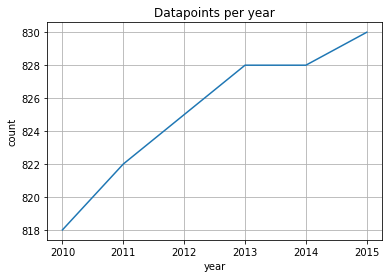

In [12]:
# Explore distribution of observations vs year

df_years_of_data = pd.DataFrame(columns=['year', 'count'])

for year in list(raw_census_df['year'].unique()):
    count = len(raw_census_df[raw_census_df['year'] == year][['county name', 'state']])
    df_years_of_data = df_years_of_data.append({'year':year, 'count':count}, ignore_index=True)

df_years_of_data = df_years_of_data.apply(pd.to_numeric)
sns.lineplot(data=df_years_of_data, x='year', y='count')
plt.grid()
plt.title('Datapoints per year')



In [13]:
# Surface the "county name" and "state" of counties consisting of data from only one year (2015)
data_year_2015 = raw_census_df[raw_census_df['year'] == 2015][['county name', 'state']]
data_year_2014 = raw_census_df[raw_census_df['year'] == 2014][['county name', 'state']]

pd.concat([data_year_2015, data_year_2014]).drop_duplicates(keep=False)

,county name,state
4342,Broomfield County,Colorado
4910,Athens County,Ohio


In [14]:
# Return all counties with 6 years of data

six_years = raw_census_df.groupby(['county name', 'state'])['year'].count() == 6
six_years[six_years].reset_index()

,county name,state,year
0,Ada County,Idaho,True
1,Adams County,Colorado,True
2,Adams County,Illinois,True
3,Adams County,Pennsylvania,True
4,Aiken County,South Carolina,True
...,...,...,...
813,York County,Pennsylvania,True
814,York County,South Carolina,True
815,York County,Virginia,True
816,Yuba County,California,True


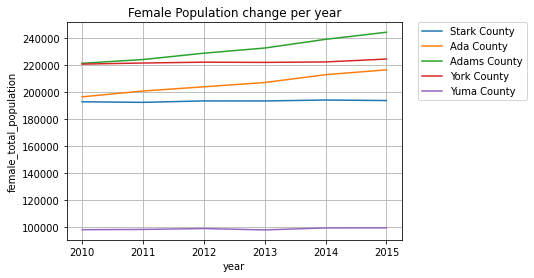

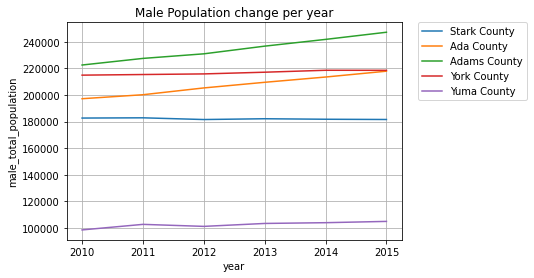

In [15]:
# Visualize population change in 5 random counties with 6 years of data

random_county_states = [
    ('Stark County', 'Ohio'), 
    ('Ada County', 'Idaho'), 
    ('Adams County', 'Colorado'), 
    ('York County', 'Pennsylvania'), 
    ('Yuma County', 'Arizona')
]

sample_raw_census_df = pd.DataFrame()

for county_name, state in random_county_states:
    tmp_df = raw_census_df.loc[(raw_census_df['county name'] == county_name) & (raw_census_df['state'] == state)]
    sample_raw_census_df = sample_raw_census_df.append(tmp_df, ignore_index=True)


sns.lineplot(data=sample_raw_census_df, x='year', y='female_total_population', hue='county name')
plt.grid()
plt.title('Female Population change per year')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()

sns.lineplot(data=sample_raw_census_df, x='year', y='male_total_population', hue='county name')
plt.grid()
plt.title('Male Population change per year')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## What we know so far:
- Various counties share the same names across states. Therefore, a single observation should be identified by the combination of `county name` and `state`.
- There are a set of null values for `county_population_increased_2015_2016` belonging to "Pike County, Kentucky".
- Not all `county name` + `state` combinations have the same number of years of data.
- All but two `county name` + `state` combinations have two or more years of data.
- __Task__: We want to collapse each `county name` + `state` combination into a single row to pass into our model. 
- __Potential solution__: compute rate of change of population fields for each `county name` + `state` over time as features. Change in population fields are normalized by time (`year`).

## How to proceed:
- Drop null rows from `raw_census_df` ("Pike County, Kentucky")
- Drop `county name` + `state` rows that contain only one year of data ("Broomfield County, Colorado" and "Athens County, Ohio")
- Normalize change in values in population fields by elapsed time in years.

# Cleaning and transforming data

In [16]:
# Clean "raw_census_df" by dropping nulls and counties with only one year of data

tmp_df = raw_census_df.dropna()
is_broomfield_county_colorado = (tmp_df['county name'] == 'Broomfield County') & (tmp_df['state'] == 'Colorado')
is_athens_county_ohio = (tmp_df['county name'] == 'Athens County') & (tmp_df['state'] == 'Ohio')
tmp_df.drop(tmp_df.loc[is_broomfield_county_colorado].index, inplace = True)
tmp_df.drop(tmp_df.loc[is_athens_county_ohio].index, inplace = True)

cleaned_census_df = tmp_df
cleaned_census_df

/home/jimmy/.cache/pypoetry/virtualenvs/nielsen-interview-project-k9tJTFJ4-py3.8/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,county name,state,county_population_increased_2015_2016,year,female_total_population,female_age_under_5_pct,female_age_5_to_9_pct,female_age_10_to_14_pct,female_age_15_to_19_pct,female_age_20_to_24_pct,...,male_age_40_to_44_pct,male_age_45_to_49_pct,male_age_50_to_54_pct,male_age_55_to_59_pct,male_age_60_to_64_pct,male_age_65_to_69_pct,male_age_70_to_74_pct,male_age_75_to_79_pct,male_age_80_to_84_pct,male_age_85_and_over_pct
0,Stark County,Ohio,False,2010,192651,5.5,6.3,6.0,6.2,5.7,...,7.0,7.4,8.1,7.4,6.2,4.8,3.1,2.6,2.0,1.5
1,Summit County,Ohio,False,2010,279592,5.6,5.8,6.2,6.5,6.1,...,6.8,7.6,8.1,7.5,5.6,3.6,3.3,2.5,2.0,1.2
2,Trumbull County,Ohio,False,2010,108490,5.4,5.9,6.3,6.2,5.0,...,6.7,7.1,8.1,6.9,7.5,5.7,3.0,2.5,2.6,1.5
3,Tuscarawas County,Ohio,False,2010,47279,5.5,5.2,7.7,6.5,4.9,...,5.5,7.2,8.1,6.2,7.2,4.0,4.0,2.4,2.5,1.4
4,Warren County,Ohio,True,2010,105706,6.4,7.0,8.5,6.4,4.2,...,6.9,8.3,7.4,5.2,5.7,3.3,2.3,1.7,1.3,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,Toa Alta Municipio,Puerto Rico,False,2015,38559,4.6,6.7,5.9,6.2,8.7,...,6.9,7.3,7.2,6.2,5.0,4.8,2.4,2.8,0.6,0.7
4947,Toa Baja Municipio,Puerto Rico,False,2015,43530,4.6,7.2,4.2,6.5,6.6,...,6.8,6.3,6.3,4.8,6.2,4.6,4.7,2.4,2.0,2.0
4948,Trujillo Alto Municipio,Puerto Rico,False,2015,36804,4.4,4.9,6.5,5.7,7.1,...,7.2,6.6,6.4,4.7,6.7,5.9,3.0,2.2,2.0,1.5
4949,Bayamón Municipio,Puerto Rico,False,2015,99486,4.4,5.4,4.7,5.9,6.5,...,4.2,6.2,6.5,5.6,5.4,4.3,4.5,3.1,2.7,2.1


In [17]:
# Extracting all unique "county name" and "state"

unique_county_states = cleaned_census_df[['county name', 'state', 'county_population_increased_2015_2016']].drop_duplicates()

In [18]:
# Transforming data by normalizing change in population fields by year 

feature_target_df = pd.DataFrame()

column_names = list(cleaned_census_df.columns[4:])


for _, row in unique_county_states.iterrows():
    county_name = row['county name']
    state = row['state']
    
    unique_row_df = cleaned_census_df.loc[(raw_census_df['county name'] == county_name) & (raw_census_df['state'] == state)]
    
    min_year = unique_row_df['year'].min()
    max_year = unique_row_df['year'].max()
    
    diff_year = max_year - min_year
    
    insert_dict = dict()
    insert_dict['county name'] = county_name
    insert_dict['state'] = state
    insert_dict['county_population_increased_2015_2016'] = row['county_population_increased_2015_2016']
    
    for col_name in column_names:
        earliest_col_value = unique_row_df[unique_row_df['year'] == min_year][col_name].values
        latest_col_value = unique_row_df[unique_row_df['year'] == max_year][col_name].values
                
        col_rate_of_change = (latest_col_value - earliest_col_value)/diff_year
        
        insert_dict[f'{col_name}_rate'] = col_rate_of_change 
     
    feature_target_df = feature_target_df.append(pd.DataFrame(insert_dict), ignore_index=True)    
    
feature_target_df
    

,county name,state,county_population_increased_2015_2016,female_total_population_rate,female_age_under_5_pct_rate,female_age_5_to_9_pct_rate,female_age_10_to_14_pct_rate,female_age_15_to_19_pct_rate,female_age_20_to_24_pct_rate,female_age_25_to_29_pct_rate,...,male_age_40_to_44_pct_rate,male_age_45_to_49_pct_rate,male_age_50_to_54_pct_rate,male_age_55_to_59_pct_rate,male_age_60_to_64_pct_rate,male_age_65_to_69_pct_rate,male_age_70_to_74_pct_rate,male_age_75_to_79_pct_rate,male_age_80_to_84_pct_rate,male_age_85_and_over_pct_rate
0,Stark County,Ohio,False,184.000000,-0.040000,-0.200000,0.100000,0.02,0.080000,0.08,...,-0.260000,-0.200000,-0.140000,0.000000,0.140000,0.200000,0.14,0.08,-0.020000,0.020000
1,Summit County,Ohio,False,-146.200000,-0.060000,0.020000,-0.160000,-0.10,0.000000,0.12,...,-0.120000,-0.180000,-0.140000,0.020000,0.200000,0.320000,0.04,-0.06,0.020000,0.100000
2,Trumbull County,Ohio,False,-895.400000,-0.020000,-0.160000,-0.100000,-0.14,0.200000,-0.06,...,-0.200000,-0.140000,-0.160000,0.240000,-0.120000,0.260000,0.14,0.22,-0.140000,0.060000
3,Tuscarawas County,Ohio,False,-35.600000,0.120000,0.220000,-0.520000,-0.18,0.100000,0.00,...,-0.100000,-0.260000,-0.100000,0.240000,-0.060000,0.520000,-0.20,0.14,-0.120000,0.020000
4,Warren County,Ohio,True,1236.000000,-0.120000,-0.040000,-0.200000,0.08,0.140000,-0.16,...,0.120000,-0.120000,0.100000,0.200000,0.140000,0.140000,0.18,0.04,-0.040000,0.120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,Chatham County,North Carolina,True,867.000000,-0.400000,-0.933333,0.600000,0.00,0.066667,0.20,...,-0.766667,-0.066667,0.066667,-0.133333,-0.133333,0.033333,0.40,0.10,0.066667,0.400000
823,Catoosa County,Georgia,True,47.333333,-0.033333,1.433333,-1.833333,-0.20,0.700000,0.00,...,-0.933333,-0.300000,0.266667,-0.466667,0.400000,0.600000,0.10,0.80,-0.266667,-0.333333
824,Ward County,North Dakota,False,1660.000000,0.750000,0.550000,0.300000,0.50,0.000000,0.55,...,0.700000,0.400000,0.000000,-0.200000,0.150000,0.700000,-0.70,0.10,0.150000,-0.200000
825,Rice County,Minnesota,True,159.500000,-1.200000,-0.250000,0.700000,-0.50,0.950000,0.45,...,-0.700000,-0.200000,-0.500000,0.400000,0.000000,-0.100000,0.35,0.40,-0.600000,0.350000


# Exploring processed data

<AxesSubplot:>

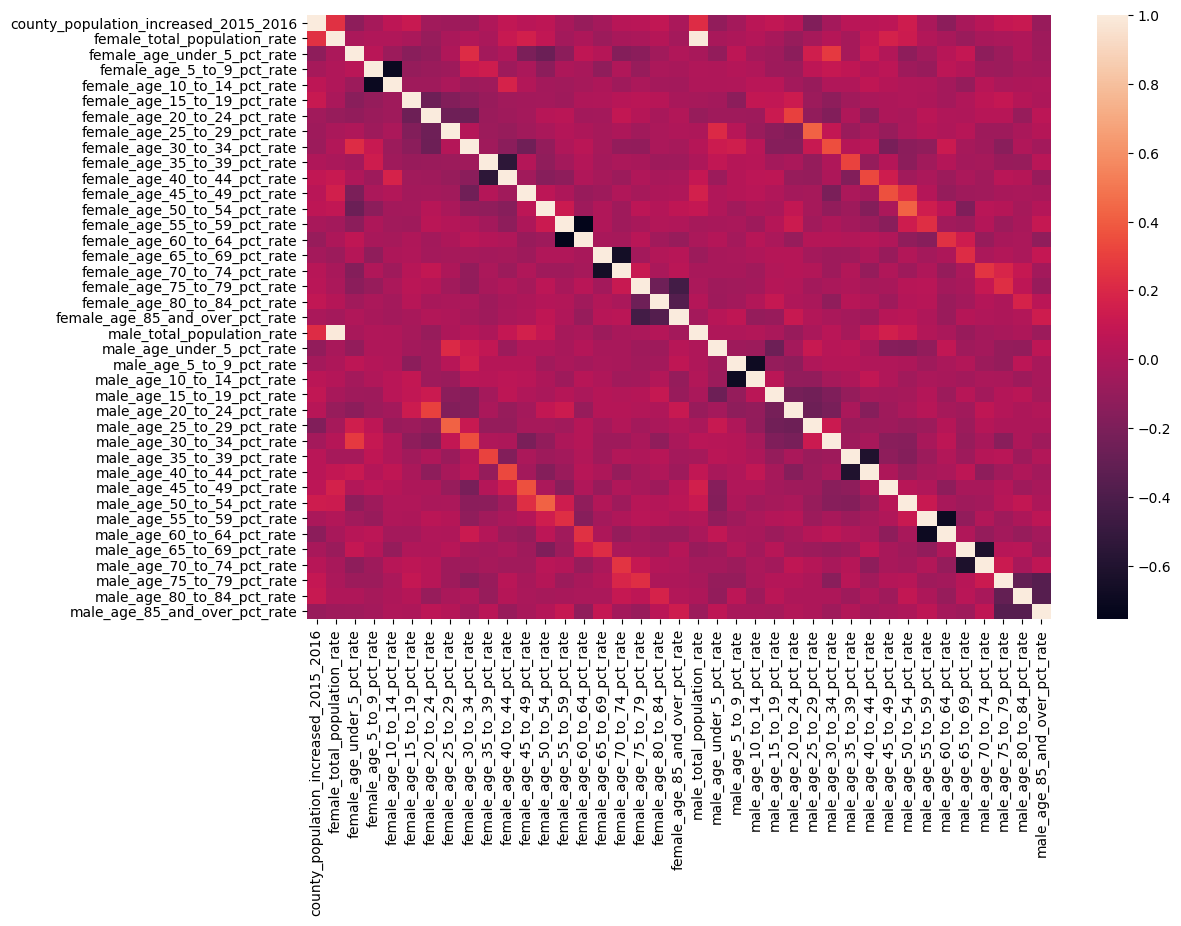

In [19]:
# Create correlation matrix to identify collinearity

corr_matrix = feature_target_df.corr()

# Correlation heatmap

plt.figure(figsize=(12,8), dpi= 100)
sns.heatmap(corr_matrix)

In [20]:
# Show any feature combinations that have a pearson correlation coeff. > 0.5 or < -0.5

significant_positive_corr = (corr_matrix > 0.5) & (corr_matrix < 1)
significant_negative_corr = (corr_matrix < -0.5) & (corr_matrix > -1)

collinear_features = getIndices(corr_matrix, (significant_positive_corr | significant_negative_corr))
collinear_features

[('male_total_population_rate', 'female_total_population_rate'),
 ('female_age_10_to_14_pct_rate', 'female_age_5_to_9_pct_rate'),
 ('female_age_5_to_9_pct_rate', 'female_age_10_to_14_pct_rate'),
 ('female_age_40_to_44_pct_rate', 'female_age_35_to_39_pct_rate'),
 ('female_age_35_to_39_pct_rate', 'female_age_40_to_44_pct_rate'),
 ('female_age_60_to_64_pct_rate', 'female_age_55_to_59_pct_rate'),
 ('female_age_55_to_59_pct_rate', 'female_age_60_to_64_pct_rate'),
 ('female_age_70_to_74_pct_rate', 'female_age_65_to_69_pct_rate'),
 ('female_age_65_to_69_pct_rate', 'female_age_70_to_74_pct_rate'),
 ('female_total_population_rate', 'male_total_population_rate'),
 ('male_age_10_to_14_pct_rate', 'male_age_5_to_9_pct_rate'),
 ('male_age_5_to_9_pct_rate', 'male_age_10_to_14_pct_rate'),
 ('male_age_40_to_44_pct_rate', 'male_age_35_to_39_pct_rate'),
 ('male_age_35_to_39_pct_rate', 'male_age_40_to_44_pct_rate'),
 ('male_age_60_to_64_pct_rate', 'male_age_55_to_59_pct_rate'),
 ('male_age_55_to_59_pct_ra

# What we know so far:
- Multiple rate features exhibit collinearity.
- Collinearity is not ideal when performing a regression, because it reduces interpretability, and reduces the statistical power of our coefficients (p-values become uncertain).
- We have 3 potential choices:
  - We can choose to remove features so that collinearity does not exist.
  - We can linearly combine the features that exhibit collinearity.
  - We can use a principal component analysis (PCA) to project our data to a lower dimensional space, thereby combining previously collinear features, and solving our collinearity problem (this is especially useful when we have many features and we want to reduce dimensionality, however this also potentially decreases interpretability).
  
For this exercise, we will be simply removing features so that collinearity does not exist, this means for a given pair of collinear features, we will remove one of the two features in the pair.

In [21]:
# Drop columns with collinearity and transform data

collinear_cols = extractOtherCollinearPair(collinear_features)

[feature_target_df.drop([col], axis=1, inplace=True) for col in collinear_cols]

features_df = feature_target_df.drop(['county name', 'state', 'county_population_increased_2015_2016'], axis=1)
features_array = features_df.values
scaled_features = StandardScaler().fit_transform(features_array)

target_list = list(feature_target_df['county_population_increased_2015_2016'])
target_list = [1 if x==True else 0 for x in target_list]


scaled_features_df = pd.DataFrame(scaled_features, index=features_df.index, columns=features_df.columns)
target_df = pd.DataFrame({'county_population_increased_2015_2016': target_list})

# Training and analyzing Logistic Regression Model

In [22]:
# Define train and test data

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features_df.values, np.ravel(target_df.values), test_size=0.3, random_state=42
)

In [23]:
# Run logistic regression and extract feature coefficients

log_reg = sm.Logit(target_df, scaled_features_df).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.610583
         Iterations 6
                                     Logit Regression Results                                    
Dep. Variable:     county_population_increased_2015_2016   No. Observations:                  827
Model:                                             Logit   Df Residuals:                      798
Method:                                              MLE   Df Model:                           28
Date:                                   Sun, 13 Jun 2021   Pseudo R-squ.:                 0.03470
Time:                                           13:24:44   Log-Likelihood:                -504.95
converged:                                          True   LL-Null:                       -523.10
Covariance Type:                               nonrobust   LLR p-value:                    0.1351
                                      coef    std err          z      P>|z|      [0.025      0.975]
--------------

From the results summary, given alpha = 0.05, the following features have a significant relationship with whether the county population increases from 2015 to 2016:
- female_total_population_rate (relatively strong positive effect)
- female_age_under_5_pct_rate (relatively moderate negative effect)
- male_age_25_to_29_pct_rate (relatively moderate negative effect)
- male_age_75_to_79_pct_rate (relatively moderate positive effect)
- male_age_80_to_84_pct_rate (relatively moderate positive effect)

Let's run a logistic regression using Sklearn and see what the accuracy is.

In [24]:
# Train and predict using sklearn logistic regression and observe accuracy

lr = LogisticRegression(random_state=0).fit(X_train, y_train)

print("\nLogistic Regression metrics: \n============================")
print(f"Accuracy: {lr.score(X_test, y_test)}")
print(f"F1 Score: {f1_score(lr.predict(X_test), y_test)}")
print(f"AUC: {roc_auc_score(y_test, lr.decision_function(X_test))}")


Logistic Regression metrics: 
Accuracy: 0.6867469879518072
F1 Score: 0.7833333333333332
AUC: 0.7496538355026309


An accuracy of 0.687, F1 score of 0.783, and area under the curve of the ROC of 0.750 isn't very good, but the purpose of the logistic regression principally was to surface any relationships between certain features and the propensity for population to increase in a given county from 2015 to 2016. While the accuracy is lack-luster, this model did allow us to easily interpret how features relate to our target variable. 

Just out of curiosity, let's see the "upper-bound" of how well a model could potentially do given this data, even at the risk of losing some level of easy interpretability. We'll use XGBoost, a model based on decision trees known for it's outstanding ability to perform quite well on many datasets.

In [25]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
xgb_model.score(X_test, y_test)

print("\nXGBoost metrics: \n============================")
print(f"Accuracy: {xgb_model.score(X_test, y_test)}")
print(f"F1 Score: {f1_score(xgb_model.predict(X_test), y_test)}")
print(f"AUC: {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])}")

/home/jimmy/.cache/pypoetry/virtualenvs/nielsen-interview-project-k9tJTFJ4-py3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGBoost metrics: 
Accuracy: 0.8232931726907631
F1 Score: 0.8674698795180724
AUC: 0.8723345333702575


We observe an accuracy of 0.823, f1 score of 0.867, and area under the ROC of 0.872. This can be used as a benchmark for developing a simpler model that also approaches similar levels of accuracy. 

# Summary

Some initial exploration was performed on the raw census data to see if any useful insight could be extracted about the characteristics of the data, variable types, potential features and additional information about the target variable. 

The intention was to create an initial statistical model that will not only reasonably predict whether a given county population increased from 2015 to 2016, but also to allow us to interpret the relationship(s) between a set of features and the target. The model of choice to start out with therefore is a logistic regression.

If we were to deploy such a model into production, we may also choose to explore additional classifiers that may not be as easily interpretable, but might return more accurate predictions--such as a support vector machine (SVM), random forest (RF), XGboost, etc. A good rule of thumb to generally follow is to deploy the simplest model as possible while still returning acceptable performance.

While working through the data, the dataset was collapsed such that each row consisted of a unique county name and state combination. To this end, the rate of change for each feature was computing (which naturally, is normalized by change in year). The data was cleaned to enable such an approach, and upon analyzing the resulting processed data, it was discovered that a few of the new features exhibited collinearity (Pearson's coefficient > 0.5). There were multiple ways to deal with this, for this exercise, I chose to remove one feature out of each set of collinear features pairs. An argument could be made for performing a PCA to deal with an abundance of collinear data, but in that case, interpretability would decrease, and there is also a chance that the lower dimension features would make the subsequent model(s) perform worse since a PCA does not take into consideration the actual response (target) variable. 

The data was standardized, then fed through a logistic regression model via statsmodels, and a summary of coefficients and their respective p-values were returned. The follow features exhibited a strong relationship with our target variable.
- female_total_population_rate (relatively strong positive effect)
- female_age_under_5_pct_rate (relatively moderate negative effect)
- male_age_25_to_29_pct_rate (relatively moderate negative effect)
- male_age_75_to_79_pct_rate (relatively moderate positive effect)
- male_age_80_to_84_pct_rate (relatively moderate positive effect)
From these results, it seems logical that a historically positive total population rate would strongly indicate a subsequent continued increase in population. What is fascinating is that the last 4 features also seem to indicate that historical increases in the younger population seem to be correlated with a decrease in subsequent total population from 2015 to 2016, whereas increases in the older population seem to correlate with increase in total population from 2015 to 2016.

Finally, a logistic regression model from Sklearn was trained and tested, along with an XGBoost for comparison. Metrics observed were the accuracy, F1 score, and the AUC. In this case, the F1 score was particularly meaningful because our dataset is unbalanced, i.e. around twice as many counties saw increases from 2015 to 2016 than decreases. From our comparison, unsurprisingly XGBoost performed much better overall owing to the fact that XGBoost is generally a highly performant and versatile algorithm.

Improvement can be made to the predictive power of our models by exploring additional model forms-- i.e. random forest, naive bayes, support vector machines, etc. Hyperparameter tuning (GridSearch or a tree parzen estimator) can also be implemented to optimize model performance along with k-fold cross validations to mitigate overfitting.

Further studies diving deeper into additional demographic implications of these results may surface more interesting insight about underlying mechanisms driving the propensity for population increase in a given county.